In [280]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import random
import OpenEXR
import Imath

In [281]:
class EXRDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.files = [f for f in os.listdir(directory) if f.endswith('.exr')]
        self.alpha_min, self.alpha_max = None, None
        self.blue_min, self.blue_max = None, None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.files[idx])
        
        # Load EXR image
        exr_file = OpenEXR.InputFile(file_path)
        dw = exr_file.header()['dataWindow']
        width = dw.max.x - dw.min.x + 1
        height = dw.max.y - dw.min.y + 1
        assert(width == 256 and height == 256)
        
        # Extract channels
        channels = exr_file.channels(['A', 'B'])  # Alpha and Blue channels
        alpha = np.frombuffer(channels[0], dtype=np.float32).reshape(height, width)
        blue = np.frombuffer(channels[1], dtype=np.float32).reshape(height, width)

        # Data in the simulation already should be between -1 and 1. Bette results so far with no normalization
        # Store original min and max values for un-normalizing later
        # self.alpha_min, self.alpha_max = alpha.min(), alpha.max()
        # self.blue_min, self.blue_max = blue.min(), blue.max()
        
        # Normalize alpha and blue channels to [0, 1]
        # alpha = (alpha - alpha.min()) / (alpha.max() - alpha.min())
        # blue = (blue - blue.min()) / (blue.max() - blue.min())
        
        # Convert to tensors
        alpha = torch.tensor(alpha, dtype=torch.float32).unsqueeze(0)  # (1, H, W) as input
        blue = torch.tensor(blue, dtype=torch.float32).unsqueeze(0)  # (1, H, W) as target
        
        return alpha, blue  # Return input (alpha) and target (blue)


In [282]:
dataset = EXRDataset('C:/Users/epuls/OneDrive/Desktop/DataTest/')
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'{train_loader.dataset.__len__()} training samples')
print(f'{val_loader.dataset.__len__()} validation samples')
print(f'{test_loader.dataset.__len__()} test samples')


300 training samples
100 validation samples
100 test samples


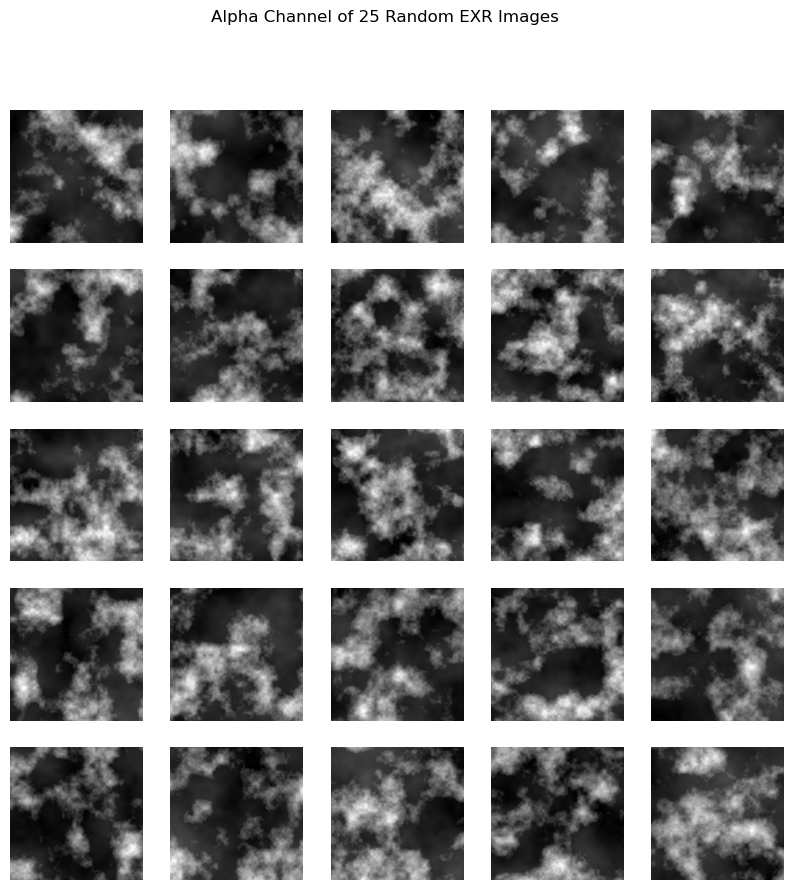

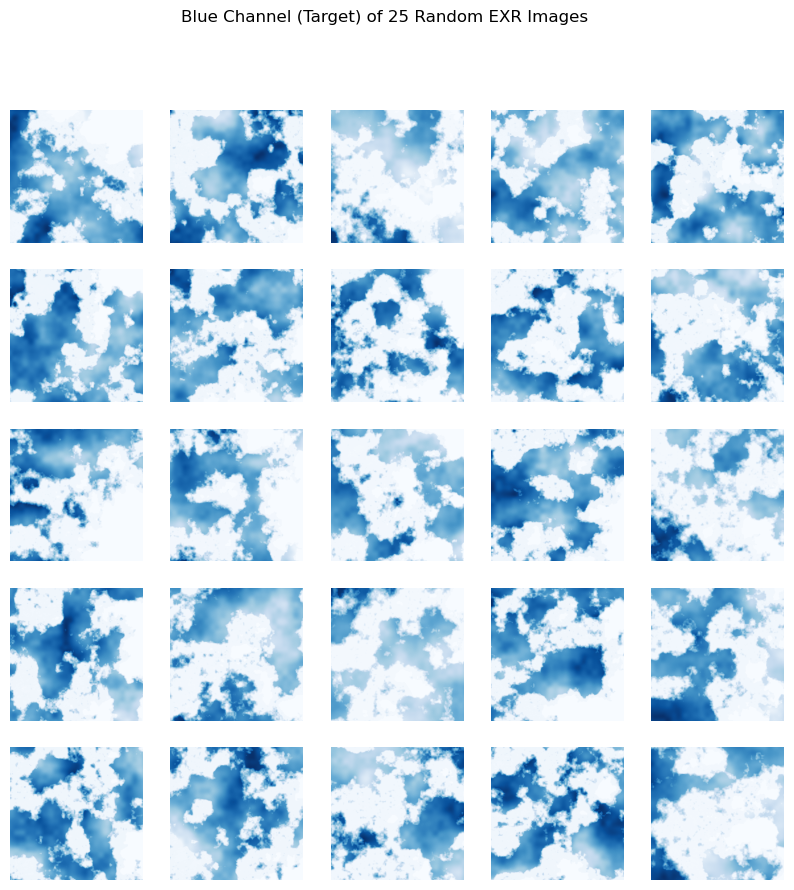

In [283]:
# Function to plot 25 random images
def plot_random_images(dataset, num_images=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(dataset), num_images, replace=False)
    for i in range(num_images):
        alpha, blue = dataset[indices[i]]
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(alpha.squeeze(), cmap='gray')  # Show the alpha channel (input)
        plt.axis('off')
    plt.suptitle(f"Alpha Channel of {num_images} Random EXR Images")
    plt.show()
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        alpha, blue = dataset[indices[i]]
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(blue.squeeze(), cmap='Blues')  # Show the blue channel (target)
        plt.axis('off')
    plt.suptitle(f"Blue Channel (Target) of {num_images} Random EXR Images")
    plt.show()

# Plot 25 random images from the dataset
plot_random_images(dataset)


In [284]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Define downsampling layers to maintain 256x256 resolution
        self.downsample1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.downsample2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.downsample3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)  # Final layer to output a single channel
        
        # Define an adaptive layer to reshape to exactly 256x256 if necessary
        self.output_layer = nn.Conv2d(1, 1, kernel_size=3, padding=1)  # Further adjust output if needed

    def forward(self, x):
        # Apply convolution layers with ReLU activation
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        
        # Apply downsampling layers to maintain 256x256 resolution
        x = torch.relu(self.downsample1(x))
        x = torch.relu(self.downsample2(x))
        x = self.downsample3(x)
        
        # Ensure final output is 256x256
        x = self.output_layer(x)
        
        return x
    

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        
        # Initial Convolution Layers with BatchNorm and LeakyReLU
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.LeakyReLU(0.1))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(0.1))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(0.1))
        
        # Downsampling Layers with Dropout
        self.downsample1 = nn.Sequential(nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.Dropout(0.2), nn.LeakyReLU(0.1))
        self.downsample2 = nn.Sequential(nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.Dropout(0.2), nn.LeakyReLU(0.1))
        
        # Final Downsampling Layer
        self.downsample3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        
        # Optional Output Layer for further adjustment
        self.output_layer = nn.Conv2d(1, 1, kernel_size=3, padding=1)
    
    def forward(self, x):
        # Forward pass with added skip connections
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)  # Apply first skip connection
        
        # Downsample with dropout and activations
        x = self.downsample1(x)
        x = self.downsample2(x)
        x = self.downsample3(x)
        
        # Final output adjustment
        x = self.output_layer(x)
        
        return x


In [285]:
import torch.nn.functional as F
def calculate_mass(tensor):
    # Sum all pixel values in the tensor to get the total mass
    return tensor.sum()


def conservation_loss_1(predicted, target, mass_weight=0.5):
    """
    Conservation-aware loss function that only applies conservation on the blue channel.
    
    Parameters:
    - predicted (torch.Tensor): Predicted tensor from the model
    - target (torch.Tensor): Ground truth tensor
    - mass_weight (float): Weighting factor for the conservation term in the loss
    
    Returns:
    - torch.Tensor: The calculated loss
    """
    # Calculate the mean squared error loss as usual
    mse_loss = F.mse_loss(predicted, target)
    
    # Extract the blue channel (assuming the blue channel is at index 2)
    predicted_blue = predicted[:, 0, :, :]  # Adjust this index to match the position of your blue channel
    target_blue = target[:, 0, :, :]

    # Calculate the mass conservation loss for the blue channel only
    predicted_mass = predicted_blue.sum()
    target_mass = target_blue.sum()
    mass_loss = torch.abs(predicted_mass - target_mass)

    # Combine the two losses
    total_loss = mse_loss + mass_weight * mass_loss
    return total_loss


def conservation_loss(predicted, target, mass_weight=0.01):
    mse_loss = F.mse_loss(predicted, target)

    # Extract the blue channel
    predicted_blue = predicted[:, 0, :, :] 
    target_blue = target[:, 0, :, :]

    # Calculate conservation error per pixel instead of total
    predicted_mass = predicted_blue.sum(dim=(1, 2)) / predicted_blue.numel()  # Normalize by the number of elements
    target_mass = target_blue.sum(dim=(1, 2)) / target_blue.numel()  # Normalize by the number of elements
    mass_loss = torch.abs(predicted_mass - target_mass).mean()  # Take the mean difference across batches

    total_loss = mse_loss + mass_weight * mass_loss
    return total_loss



In [286]:
# Initialize the models
# model = SimpleCNN()
model = ImprovedCNN()
model_loss = ImprovedCNN()
criterion = nn.MSELoss()  # Mean Squared Error for pixel-wise regression
criterion_loss = conservation_loss
# criterion = nn.CrossEntropyLoss()
# criterion = conservation_loss  # Custom loss function
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
optimizer_loss = optim.AdamW(model_loss.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Set device for training (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model_loss.to(device)
print(f"Training on {device}")


Training on cuda


In [287]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        train_loss = 0.0
        for inputs, targets in train_loader:
            # Move data to device if using GPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            # No conservation of mass loss
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation loss
        val_loss = evaluate_model(model, val_loader, criterion)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.25f}, Val Loss: {val_loss:.25f}')

# Evaluation Function
def evaluate_model(model, loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradients needed
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # loss = conservation_loss(outputs, targets, mass_weight=0.1)
            val_loss += loss.item()
    return val_loss / len(loader)


In [288]:
# Verify shapes of input and output
# print(f'{len(train_loader.dataset[1])}, {len(val_loader.dataset[0])}')
# Start Training
"""for inputs, targets in train_loader:
    print(f'''inputs: {inputs.shape}, targets: {targets.shape}''')
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    print(outputs.shape)
    break"""
print(f'Training with conservation of mass loss')
train_model(model_loss, train_loader, val_loader, criterion_loss, optimizer_loss, epochs=10)
print(f'\nTraining with MSE loss')
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Training with conservation of mass loss
Epoch 1/10, Train Loss: 0.0075168985701901348470133, Val Loss: 0.0086704333578901636447878
Epoch 2/10, Train Loss: 0.0033880833622166200459758, Val Loss: 0.0018248029019949691016678
Epoch 3/10, Train Loss: 0.0017047927800663991750041, Val Loss: 0.0015808905508103115837570
Epoch 4/10, Train Loss: 0.0016149043558949703006805, Val Loss: 0.0015532763541809149841072
Epoch 5/10, Train Loss: 0.0016448554876995714543741, Val Loss: 0.0015332239729884480656380
Epoch 6/10, Train Loss: 0.0016922166105359792709351, Val Loss: 0.0015854986018634267905952
Epoch 7/10, Train Loss: 0.0016771524188745963630798, Val Loss: 0.0017053841147571802139282
Epoch 8/10, Train Loss: 0.0016025663414773972867411, Val Loss: 0.0016952112782746553421021
Epoch 9/10, Train Loss: 0.0015889872907121713879741, Val Loss: 0.0014632744215694920737747
Epoch 10/10, Train Loss: 0.0015661611074679776013652, Val Loss: 0.0014794484013691544532776

Training with MSE loss
Epoch 1/10, Train Loss: 0

In [289]:
evaluation = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {evaluation:.4f}')
evaluation_loss = evaluate_model(model_loss, test_loader, criterion_loss)
print(f'Test Loss with conservation of mass: {evaluation_loss:.4f}')

Test Loss: 0.0020
Test Loss with conservation of mass: 0.0019


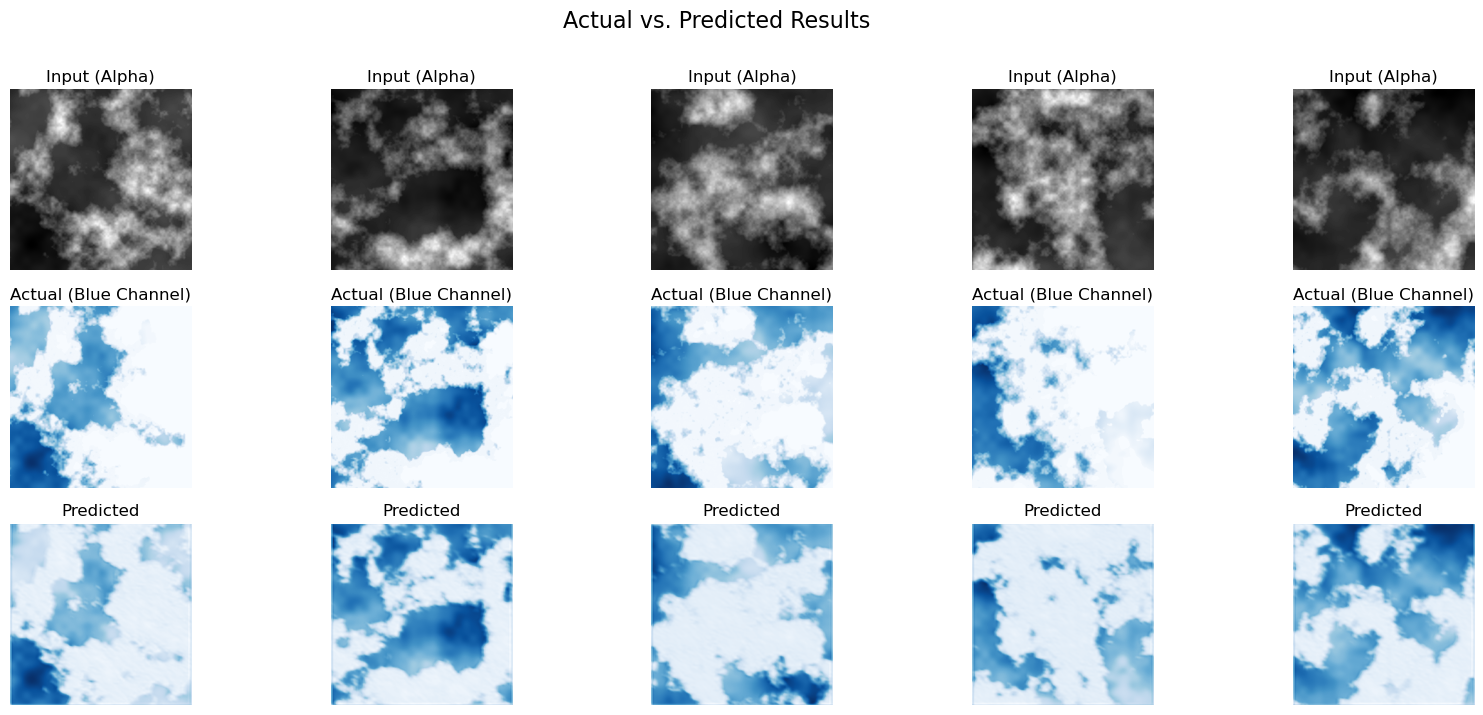

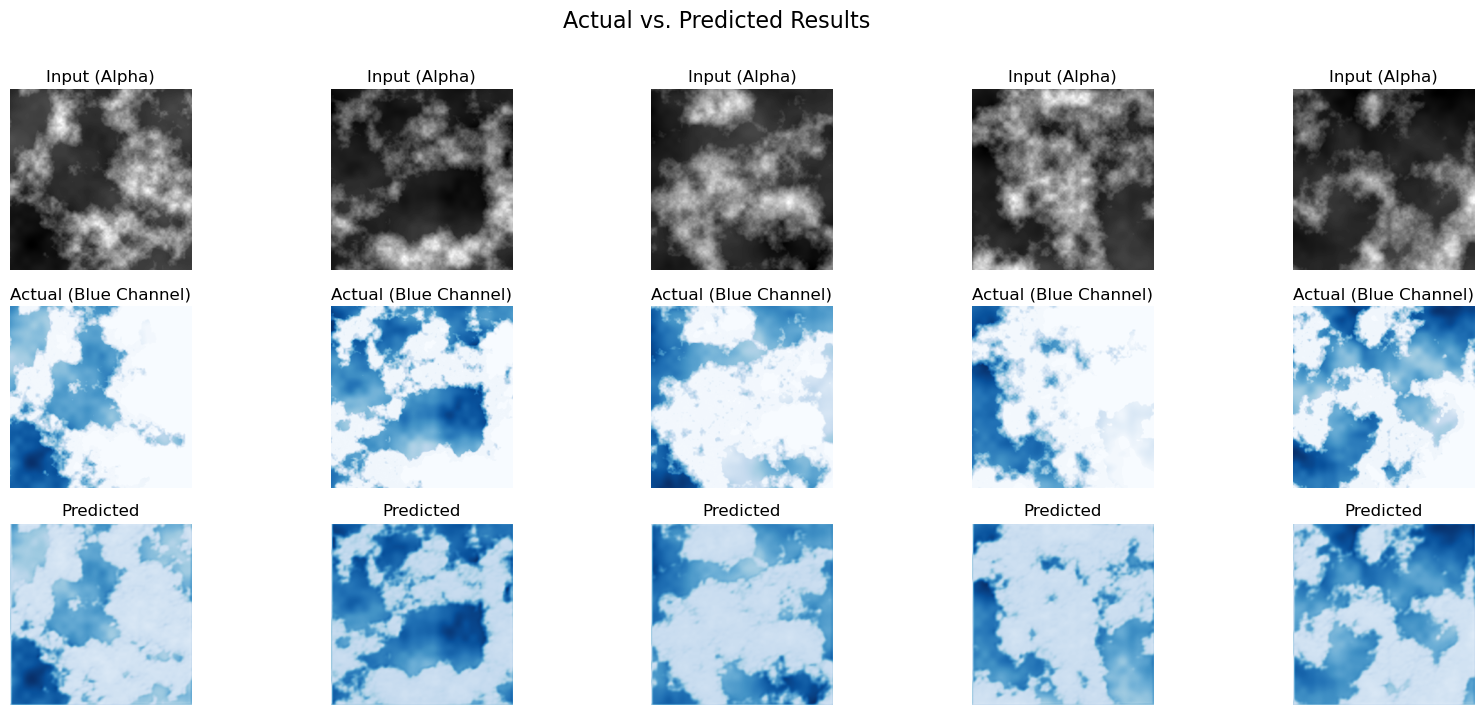

In [290]:

def plot_actual_vs_predicted(model, test_loader, num_images=10, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    
    # Grab a single batch from the test loader
    data_iter = iter(test_loader)
    images, targets = next(data_iter)

    # Move images and targets to the same device as the model
    images, targets = images.to(device), targets.to(device)

    # Generate predictions
    with torch.no_grad():  # Disable gradient calculations for inference
        predictions = model(images)

    # Plot the actual vs predicted pairs
    plt.figure(figsize=(20, 8))
    for i in range(num_images):
        # Original image (input alpha channel)
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("Input (Alpha)")
        plt.axis('off')
        
        # Actual target (Blue channel)
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(targets[i].cpu().squeeze(), cmap='Blues')
        plt.title("Actual (Blue Channel)")
        plt.axis('off')
        
        # Predicted output
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(predictions[i].cpu().squeeze(), cmap='Blues')
        plt.title("Predicted")
        plt.axis('off')
    
    plt.suptitle("Actual vs. Predicted Results", fontsize=16)
    plt.show()

# Usage:
plot_actual_vs_predicted(model, test_loader, num_images=5)
plot_actual_vs_predicted(model_loss, test_loader, num_images=5)


In [292]:
def save_channel_to_exr(alpha_data, blue_data, alpha_range, blue_range, file_path):
    """
    Save EXR with alpha channel as input and blue channel as target, reversing normalization.
    
    Parameters:
    - alpha_data (torch.Tensor): Alpha channel tensor (1 x H x W)
    - blue_data (torch.Tensor): Blue channel tensor (1 x H x W)
    - alpha_range (tuple): Min and max values for un-normalizing alpha
    - blue_range (tuple): Min and max values for un-normalizing blue
    - file_path (str): File path for the EXR file
    """
    # Convert tensors to numpy arrays
    alpha_np = alpha_data.squeeze().cpu().numpy().astype(np.float32)
    blue_np = blue_data.squeeze().cpu().numpy().astype(np.float32)

    # Un-normalize based on original min/max values
    # alpha_np = alpha_np * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
    # blue_np = blue_np * (blue_range[1] - blue_range[0]) + blue_range[0]
    
    # Define EXR header with required channels
    height, width = alpha_np.shape
    header = OpenEXR.Header(width, height)
    header['channels'] = {
        'R': Imath.Channel(Imath.PixelType(Imath.PixelType.FLOAT)),
        'G': Imath.Channel(Imath.PixelType(Imath.PixelType.FLOAT)),
        'B': Imath.Channel(Imath.PixelType(Imath.PixelType.FLOAT)),
        'A': Imath.Channel(Imath.PixelType(Imath.PixelType.FLOAT)),
    }

    # Prepare channels: Alpha in A, Blue in B, and empty R and G
    r_channel = np.zeros((height, width), dtype=np.float32).tobytes()
    g_channel = np.zeros((height, width), dtype=np.float32).tobytes()
    b_channel = blue_np.tobytes()
    a_channel = alpha_np.tobytes()
    
    # Open and write to EXR file
    exr_file = OpenEXR.OutputFile(file_path, header)
    exr_file.writePixels({'R': r_channel, 'G': g_channel, 'B': b_channel, 'A': a_channel})
    exr_file.close()
    
    print(f"Saved EXR to {file_path}")


def save_selected_pairs(model, data_loader, output_dir, device="cuda", num_pairs=10):
    """
    Save selected actual and predicted pairs as EXR files, using original filenames with "_a" and "_p" suffixes.
    
    Parameters:
    - model: Trained model for predictions
    - data_loader: DataLoader for test data
    - output_dir: Directory to save the EXR files
    - device: Device to perform computation on ("cuda" or "cpu")
    - num_pairs: Number of pairs to save
    """
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model.eval()
    model.to(device)
    
    # Get global min/max values from dataset
    dataset = data_loader.dataset.dataset  # Assuming data_loader is a Subset, get main dataset
    alpha_range = (dataset.alpha_min, dataset.alpha_max)
    blue_range = (dataset.blue_min, dataset.blue_max)
    
    selected_indices = random.sample(range(len(data_loader.dataset)), num_pairs)
    
    with torch.no_grad():
        for idx, (alpha_batch, blue_actual_batch) in enumerate(data_loader):
            alpha_batch = alpha_batch.to(device)
            blue_actual_batch = blue_actual_batch.to(device)
            predicted_batch = model(alpha_batch)

            for i in range(alpha_batch.size(0)):
                subset_index = idx * data_loader.batch_size + i
                if subset_index in selected_indices:
                    original_index = data_loader.dataset.indices[subset_index]  # Map to original index
                    original_filename = data_loader.dataset.dataset.files[original_index]
                    file_base = os.path.splitext(original_filename)[0]
                    
                    # Retrieve individual channels and min/max ranges
                    alpha = alpha_batch[i]
                    blue_actual = blue_actual_batch[i]
                    blue_predicted = predicted_batch[i]

                    # File paths
                    actual_file_path = os.path.join(output_dir, f"{file_base}_a.exr")
                    predicted_file_path = os.path.join(output_dir, f"{file_base}_p.exr")
                    
                    # Save EXR files with un-normalized channels
                    save_channel_to_exr(alpha, blue_actual, alpha_range, blue_range, actual_file_path)
                    save_channel_to_exr(alpha, blue_predicted, alpha_range, blue_range, predicted_file_path)


# Usage example
save_selected_pairs(model, test_loader, output_dir="output_exr_files", device="cuda", num_pairs=2)
save_selected_pairs(model, test_loader, output_dir="output_exr_files_cons_mass", device="cuda", num_pairs=2)



Saved EXR to output_exr_files\S_64540558_2024-11-10 230128 GMT-0500469_a.exr
Saved EXR to output_exr_files\S_64540558_2024-11-10 230128 GMT-0500469_p.exr
Saved EXR to output_exr_files\S_447030926_2024-11-10 230248 GMT-0500631_a.exr
Saved EXR to output_exr_files\S_447030926_2024-11-10 230248 GMT-0500631_p.exr
Saved EXR to output_exr_files_cons_mass\S_64540558_2024-11-10 230128 GMT-0500469_a.exr
Saved EXR to output_exr_files_cons_mass\S_64540558_2024-11-10 230128 GMT-0500469_p.exr
Saved EXR to output_exr_files_cons_mass\S_806895065_2024-11-10 221727 GMT-0500420_a.exr
Saved EXR to output_exr_files_cons_mass\S_806895065_2024-11-10 221727 GMT-0500420_p.exr
